## Importing Libraries

In [11]:
!pip install tensorflow

In [2]:
# Import the necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

# lists all the files in the directory
from glob import glob

# used for audio processing
import librosa
import librosa.display

# playing audio files in the notebook
import IPython.display as ipd

# import test train split for stratified sampling
from sklearn.model_selection import train_test_split

# import deep learing modules
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import BatchNormalization
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

import os
import shutil

from tqdm import tqdm

## Function to Reorganize and Rename Tomato Dataset

In [1]:
import os

# List the contents of /kaggle/input to see available datasets
input_dir = "/kaggle/input"
print("Contents of /kaggle/input:")
# print(os.listdir(input_dir))

Contents of /kaggle/input:


In [3]:
import os
import shutil

def rename_and_merge_tomato(source_path, destination_path):
    tomato_path = os.path.join(source_path, "Tomato")  # Target only the Tomato folder

    print(f"Checking Tomato path: {tomato_path}")  # Print to verify the path
    if os.path.isdir(tomato_path):
        print(f"Found Tomato directory: {tomato_path}")

        for split in ['Train', 'Val', 'Test']:  # Loop through Train, Val, Test
            split_path = os.path.join(tomato_path, split)
            if os.path.isdir(split_path):
                print(f"Found split: {split_path}")

                for condition in os.listdir(split_path):  # E.g., Healthy, Late Blight
                    condition_path = os.path.join(split_path, condition)

                    # Check if the condition directory exists and is not hidden
                    if os.path.isdir(condition_path) and not condition.startswith('.'):
                        print(f"Found condition folder: {condition_path}")
                        
                        # Handle naming convention for the new folder
                        if condition.lower() == "healthy":
                            new_folder_name = f"Tomato_Healthy"
                        else:
                            new_folder_name = f"Tomato_{condition.replace(' ', '_')}"
                        
                        # Create the destination folder if not exists
                        target_folder = os.path.join(destination_path, split, new_folder_name)
                        os.makedirs(target_folder, exist_ok=True)
                        print(f"Created target folder: {target_folder}")
                        
                        # Now, move the images to the renamed folder
                        for img in os.listdir(condition_path):
                            img_path = os.path.join(condition_path, img)
                            
                            if os.path.isfile(img_path):  # Ensure it's a file
                                dest_path = os.path.join(target_folder, img)
                                shutil.copy(img_path, dest_path)
                                print(f"Moved file {img} to {target_folder}")
                    else:
                        print(f"Condition folder is not valid or hidden: {condition_path}")
            else:
                print(f"Split folder does not exist: {split_path}")
    else:
        print(f"Tomato directory not found at {tomato_path}")

# Paths to source and destination
source_path = "/kaggle/input"
destination_path = "/kaggle/working/"

# Execute the function for Tomato
rename_and_merge_tomato(source_path, destination_path)
print("Tomato dataset reorganized and renamed successfully!")


Checking Tomato path: /kaggle/input/Tomato
Found Tomato directory: /kaggle/input/Tomato
Found split: /kaggle/input/Tomato/Train
Found condition folder: /kaggle/input/Tomato/Train/Early Blight
Created target folder: /kaggle/working/Train/Tomato_Early_Blight
Moved file e56354a5-5e3f-4ed6-bfe5-3c783a32dc98___RS_Erly.B 9413_flipTB.JPG to /kaggle/working/Train/Tomato_Early_Blight
Moved file cf8c6e28-201c-4c8e-994f-8dcf98362e64___RS_Erly.B 7651.JPG to /kaggle/working/Train/Tomato_Early_Blight
Moved file e11ee1f8-8de2-4d9c-a0c1-86bc42350fd9___RS_Erly.B 9472.JPG to /kaggle/working/Train/Tomato_Early_Blight
Moved file e94d68c8-f185-4b3d-9b44-ad12e3dc891d___RS_Erly.B 9598.JPG to /kaggle/working/Train/Tomato_Early_Blight
Moved file cf7acf3d-e079-4587-b3e8-bafe507c40d5___RS_Erly.B 8246_180deg.JPG to /kaggle/working/Train/Tomato_Early_Blight
Moved file c35fc6de-4796-4f7a-a350-7bff160cbbd5___RS_Erly.B 7740_180deg.JPG to /kaggle/working/Train/Tomato_Early_Blight
Moved file 99cfe9bb-77a1-4bd6-9c48-58f

## Preparing the Tomato Dataset for Training with DataLoaders

In [4]:
# Paths for the renamed dataset
TRAIN_PATH = '/kaggle/working/Train'
VAL_PATH = '/kaggle/working/Val'
TEST_PATH = '/kaggle/working/Test'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = ImageFolder(VAL_PATH, transform=transform)
test_dataset = ImageFolder(TEST_PATH, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print class names
print(f"Classes: {train_dataset.classes}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Classes: ['Tomato_Bacterial_Spot', 'Tomato_Early_Blight', 'Tomato_Healthy', 'Tomato_Late_Blight', 'Tomato_Septoria_Leaf_Spot', 'Tomato_Yellow_Leaf_Curl_Virus']
Number of classes: 6
Training samples: 11105
Validation samples: 2495
Test samples: 280


# Class Distribution

In [6]:
from collections import Counter

# `train_dataset` is an ImageFolder dataset
class_counts = Counter([item[1] for item in train_dataset])
print(class_counts)

Counter({5: 1961, 2: 1926, 1: 1920, 3: 1851, 4: 1745, 0: 1702})


In [7]:
from collections import Counter

# `train_dataset` is an ImageFolder dataset
class_counts = Counter([item[1] for item in train_dataset])

# Print the class names and their counts
class_names = train_dataset.classes
class_counts_named = {class_names[i]: class_counts[i] for i in range(len(class_names))}

print(class_counts_named)

{'Tomato_Bacterial_Spot': 1702, 'Tomato_Early_Blight': 1920, 'Tomato_Healthy': 1926, 'Tomato_Late_Blight': 1851, 'Tomato_Septoria_Leaf_Spot': 1745, 'Tomato_Yellow_Leaf_Curl_Virus': 1961}


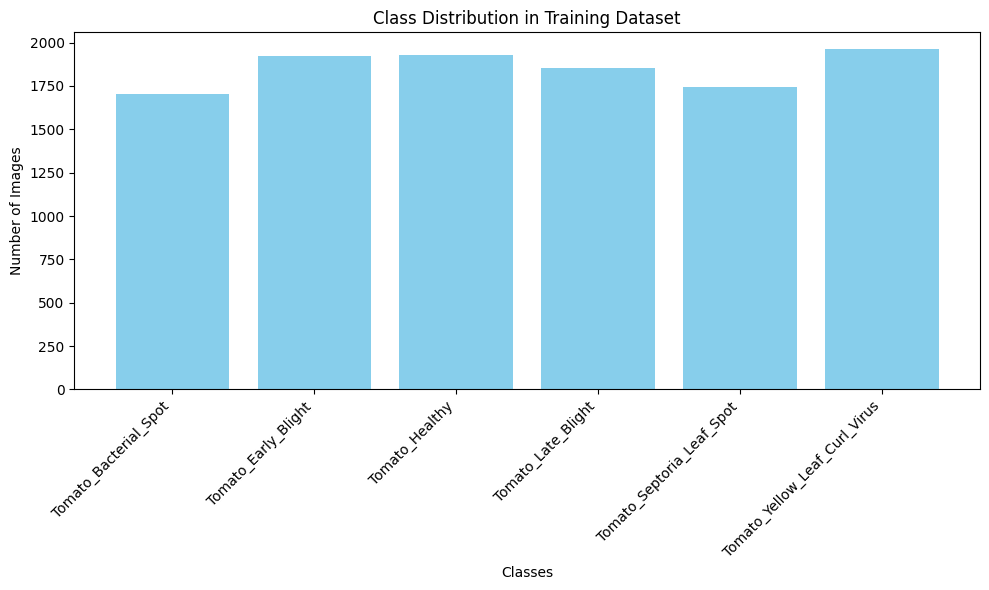

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# `train_dataset` is an ImageFolder dataset
class_counts = Counter([item[1] for item in train_dataset])

# Map numerical labels to class names
class_names = train_dataset.classes
class_counts_named = {class_names[i]: class_counts[i] for i in range(len(class_names))}

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(class_counts_named.keys(), class_counts_named.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45, ha='right')  # Rotate class names for better visibility
plt.tight_layout()  # Adjust spacing for readability
plt.show()
